In [1]:
import cv2
from ultralytics import YOLO
from threading import Thread

# Threaded camera stream for faster video capture
class CameraStream:
    def __init__(self, src=0):
        # Open webcam (CAP_DSHOW is faster on Windows)
        self.cap = cv2.VideoCapture(src, cv2.CAP_DSHOW)
        # Reduce frame size for better speed
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        (self.ret, self.frame) = self.cap.read()
        self.running = True
        # Start background thread to read frames continuously
        Thread(target=self.update, daemon=True).start()

    def update(self):
        while self.running:
            (self.ret, self.frame) = self.cap.read()

    def read(self):
        return self.ret, self.frame

    def stop(self):
        self.running = False
        self.cap.release()

def main():
    # Load YOLOv8 small model for higher accuracy than YOLOv8n
    model = YOLO("yolov8s.pt")

    # Start threaded camera capture
    stream = CameraStream(0)

    while True:
        # Get the latest frame from the stream
        ret, frame = stream.read()
        if not ret:
            break

        # Run YOLO detection with confidence threshold 0.4
        results = model(frame, conf=0.4, verbose=False)

        # Process detection results
        for r in results:
            boxes = r.boxes
            for box in boxes:
                # Get bounding box coordinates
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                # Get class name and confidence
                cls = model.names[int(box.cls[0])]
                conf = float(box.conf[0]) * 100
                label = f"{cls} {conf:.1f}%"

                # Draw bounding box and label on the frame
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, label, (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display the frame
        cv2.imshow("YOLOv8 Detection (s model)", frame)

        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break

    # Release camera and close windows
    stream.stop()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()

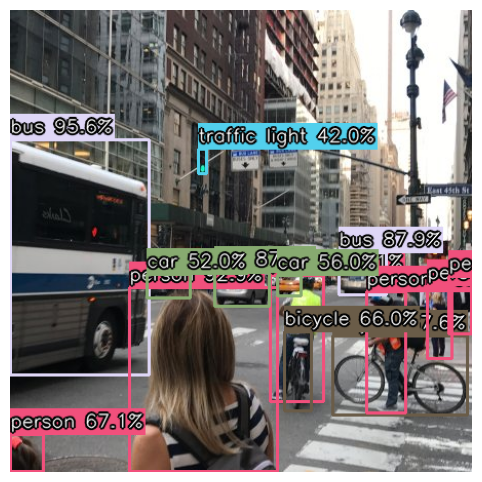

True

In [19]:
import cv2
from ultralytics import YOLO
from matplotlib import pyplot as plt
import random

# Load YOLOv8s model
model = YOLO("yolov8s.pt")

# Load the image
img = cv2.imread("input.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Generate random colors for each class
colors = {cls: (random.randint(50,255), random.randint(50,255), random.randint(50,255)) 
          for cls in model.names.values()}

# Run YOLO detection
results = model(img, conf=0.4, verbose=False)

# Draw bounding boxes with improved label visualization
for r in results:
    for box in r.boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cls = model.names[int(box.cls[0])]
        conf = float(box.conf[0]) * 100
        label = f"{cls} {conf:.1f}%"
        
        color = colors[cls]  # pick color for this class

        # Draw rectangle
        cv2.rectangle(img_rgb, (x1, y1), (x2, y2), color, 2)
        
        # Get label size
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        
        # Draw label background
        cv2.rectangle(img_rgb, (x1, y1-25), (x1+w, y1), color, -1)
        
        # Put outlined text (black then white)
        cv2.putText(img_rgb, label, (x1, y1-7), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (0,0,0), 3, cv2.LINE_AA)   # Black outline
        cv2.putText(img_rgb, label, (x1, y1-7), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.6, (255,255,255), 1, cv2.LINE_AA) # White text

# Show the image
plt.figure(figsize=(10,6))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# Save output
cv2.imwrite("output.jpg", cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR))